In [10]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
import tensorflow as tf
import random
import io
import cv2
from tensorflow.keras.utils import normalize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from scipy.ndimage import rotate
from nibabel import load
from IPython.display import Image, display
from skimage.exposure import rescale_intensity
from skimage.segmentation import mark_boundaries
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, Callback, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [17]:
image_directory = 'C:/Users/Mittal/Desktop/thoracic_seg/raw_images/'
mask_directory = 'C:/Users/Mittal/Desktop/thoracic_seg/segmentations/'

image_dataset = []
mask_dataset = []
sliced_image_dataset = []
sliced_mask_dataset = []
image_names = []
sliced_image_names = []

images = sorted(os.listdir(image_directory))
for i, image_name in enumerate(images):    
    if (image_name.split('.')[1] == 'nii'):
        image = nib.load(image_directory+image_name)
        image = np.array(image.get_fdata())
        image_dataset.append(np.array(image))
        image_names.append(image_name.split('.')[0])

masks = sorted(os.listdir(mask_directory))
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'nii'):
        image = nib.load(mask_directory+image_name)
        image = np.array(image.get_fdata())
        mask_dataset.append(np.array(image))

original_data_size = 0

for i in range(len(image_dataset)):
    if image_dataset[i].shape[2] < 30:
        for j in range(mask_dataset[i].shape[2]):
            sliced_image_dataset.append(image_dataset[i][:,:,j])
            sliced_mask_dataset.append(mask_dataset[i][:,:,j])
            sliced_image_names.append(image_names[i] + '-' + str(j))
    else:
        for j in range(mask_dataset[i].shape[2]):
            sliced_image_dataset.append(image_dataset[i][:,:,j])
            sliced_mask_dataset.append(mask_dataset[i][:,:,j])
            sliced_image_names.append(image_names[i] + '-' + str(j))


sliced_image_dataset = np.array(sliced_image_dataset)
sliced_mask_dataset = np.array(sliced_mask_dataset)
image_names = np.array(image_names)
sliced_image_names = np.array(sliced_image_names)

#Encode labels... but multi dim array so need to flatten, encode and reshape
labelencoder = LabelEncoder()
n, h, w = sliced_mask_dataset.shape
sliced_masks_reshaped = sliced_mask_dataset.reshape(-1,1)
sliced_masks_reshaped_encoded = labelencoder.fit_transform(sliced_masks_reshaped)
sliced_masks_encoded_original_shape = sliced_masks_reshaped_encoded.reshape(n, h, w)

sliced_image_dataset = np.expand_dims(sliced_image_dataset, axis=3)
sliced_image_dataset = normalize(sliced_image_dataset, axis=1)

sliced_mask_dataset = np.expand_dims(sliced_masks_encoded_original_shape, axis=3)

c:\Users\Mittal\anaconda3\envs\tf2.5\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
num_classes = 7

# Dice Coefficient
def dice_coef(y_true, y_pred):
    total_dice = 0.0
    num_class = 0.0
    for class_idx in range(num_classes):
        y_true_class = y_true[..., class_idx]
        y_pred_class = y_pred[..., class_idx]
        y_true_f = tf.keras.backend.flatten(y_true_class)
        y_pred_f = tf.keras.backend.flatten(y_pred_class)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        dice = (2. * intersection) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-7)
        total_dice = total_dice + dice
        num_class = num_class + 1.0
    mean_dice_score = total_dice / num_class
    return mean_dice_score

# True Positive Rate (TPR)
def tpr(y_true, y_pred, threshold=0.5):
    total_tpr = 0
    num_class = 0
    for class_idx in range(num_classes):
        y_true_class = y_true[..., class_idx]
        y_pred_class = y_pred[..., class_idx]
        y_pred_pos = tf.cast(y_pred_class > threshold, tf.float32)
        y_true_pos = tf.cast(y_true_class > threshold, tf.float32)
        true_pos = tf.reduce_sum(tf.cast(tf.logical_and(y_true_pos == 1, y_pred_pos == 1), tf.float32))
        actual_pos = tf.reduce_sum(tf.cast(y_true_pos, tf.float32))
        tpr = true_pos / (actual_pos + tf.keras.backend.epsilon())
        total_tpr += tpr
        num_class += 1
    mean_tpr = total_tpr / num_class
    return mean_tpr

# False Positive Rate (FPR)
def fpr(y_true, y_pred, threshold=0.5):
    total_fpr = 0
    num_class = 0
    for class_idx in range(num_classes):
        y_true_class = y_true[..., class_idx]
        y_pred_class = y_pred[..., class_idx]
        y_pred_pos = tf.cast(y_pred_class > threshold, tf.float32)
        y_true_neg = tf.cast(y_true_class <= threshold, tf.float32)
        false_pos = tf.reduce_sum(tf.cast(tf.logical_and(y_true_neg == 1, y_pred_pos == 1), tf.float32))
        actual_neg = tf.reduce_sum(tf.cast(y_true_neg, tf.float32))
        fpr = false_pos / (actual_neg + tf.keras.backend.epsilon())
        total_fpr += fpr
        num_class += 1
    mean_fpr = total_fpr / num_class
    return mean_fpr

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1, num_classes])
    y_pred_f = tf.reshape(y_pred, [-1, num_classes])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0) + smooth)
    return 1.0 - tf.reduce_mean(score)

def combined_loss(y_true, y_pred):
    cce_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
    dice_loss = 1 - dice_coef(y_true, y_pred)
    return cce_loss + dice_loss

In [13]:
def multi_unet_model(n_classes=7, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    p5 = MaxPooling2D(pool_size=(2, 2))(c5)
    
    c6 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.3)(c6)
    c6 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)
    
    # Expansive path 
    u7 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c5])
    c7 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)
     
    u8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c4])
    c8 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)
     
    u9 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c3])
    c9 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)
     
    u10 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c2])
    c10 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = BatchNormalization()(c10)
    c10 = Dropout(0.1)(c10)
    c10 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
    c10 = BatchNormalization()(c10)
     
    u11 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = concatenate([u11, c1], axis=3)
    c11 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
    c11 = BatchNormalization()(c11)
    c11 = Dropout(0.1)(c11)
    c11 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
    c11 = BatchNormalization()(c11)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c11)     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef, tpr, fpr])
    model.summary()
    
    return model

In [14]:
IMG_HEIGHT = sliced_image_dataset.shape[0]
IMG_WIDTH  = sliced_image_dataset.shape[1]
IMG_CHANNELS = sliced_image_dataset.shape[2]

In [15]:
def get_model():
    return multi_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = tf.keras.models.load_model('C:/Users/Mittal/Desktop/thoracic_seg/models/multi_unet_model_3.h5', custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef, 'tpr': tpr, 'fpr': fpr})

# model = get_model()

# model.load_weights('C:/Users/Mittal/Desktop/thoracic_seg/models/cylinder_unet_model_1.h5')

In [19]:
filewise_predictions = {filename: [] for filename in image_names}
for idx, filename in enumerate(image_names):
    num_slices_per_image = image_dataset[idx].shape[2]  # Assuming image_dataset is accessible here
    start_index = sum(image_dataset[i].shape[2] for i in range(idx))  # Start index for slices of this image
    for z in range(num_slices_per_image):
        test_img = sliced_image_dataset[start_index + z]
        ground_truth = sliced_mask_dataset[start_index + z]
        test_img_norm = test_img[:,:,0][:,:,None]
        test_img_input = np.expand_dims(test_img_norm, 0)
        prediction = (model.predict(test_img_input))
        predicted_img = np.argmax(prediction, axis=3)[0,:,:]
        
        filewise_predictions[filename].append(prediction)

# Saving 3D predictions
for filename, predictions in filewise_predictions.items():
    if len(predictions) > 0:  # Check if predictions are available
        three_d_predictions_volume = np.stack(predictions, axis=-1)
        affine = np.eye(4)
        nii_img = nib.Nifti1Image(three_d_predictions_volume, affine)
        nib.save(nii_img, f'C:/Users/Mittal/Desktop/thoracic_seg/cylinder_niipredictions/{filename}.nii')
    else:
        print(f"No predictions available for {filename}.")

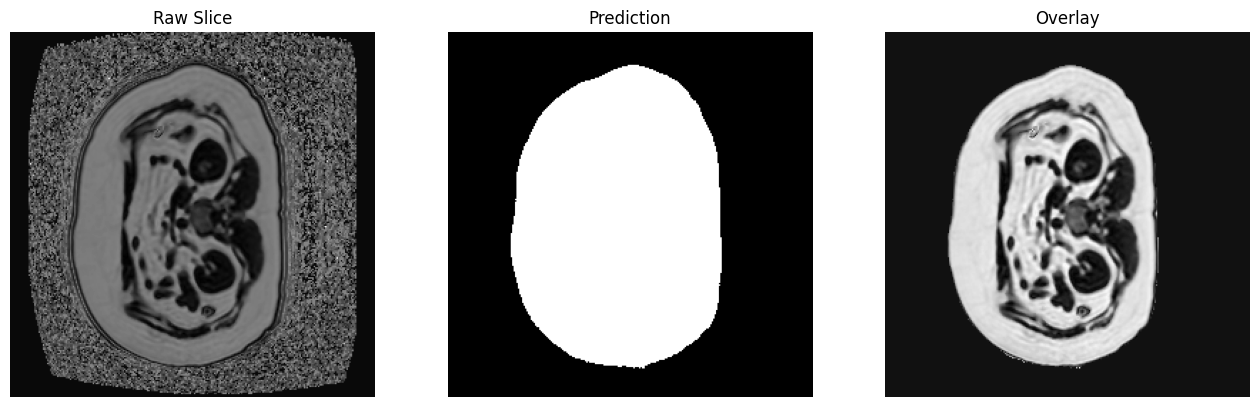

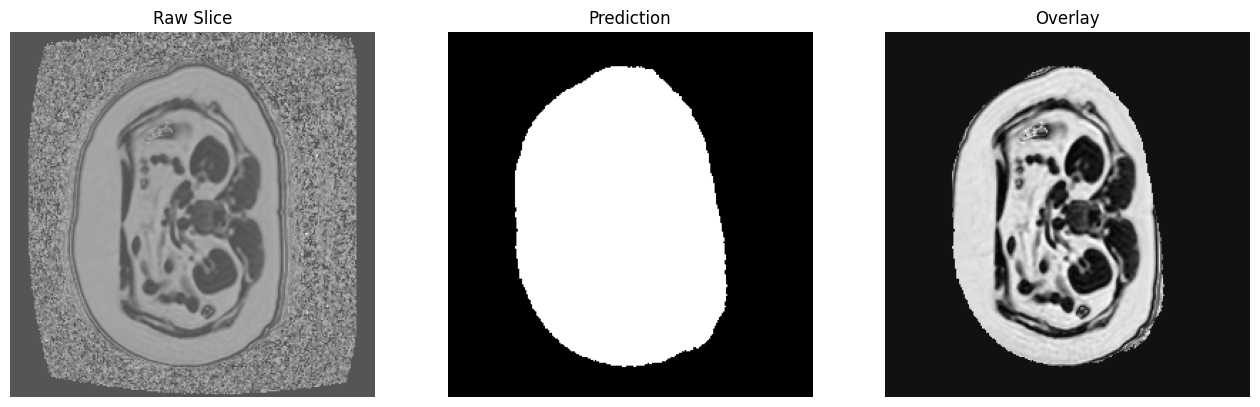

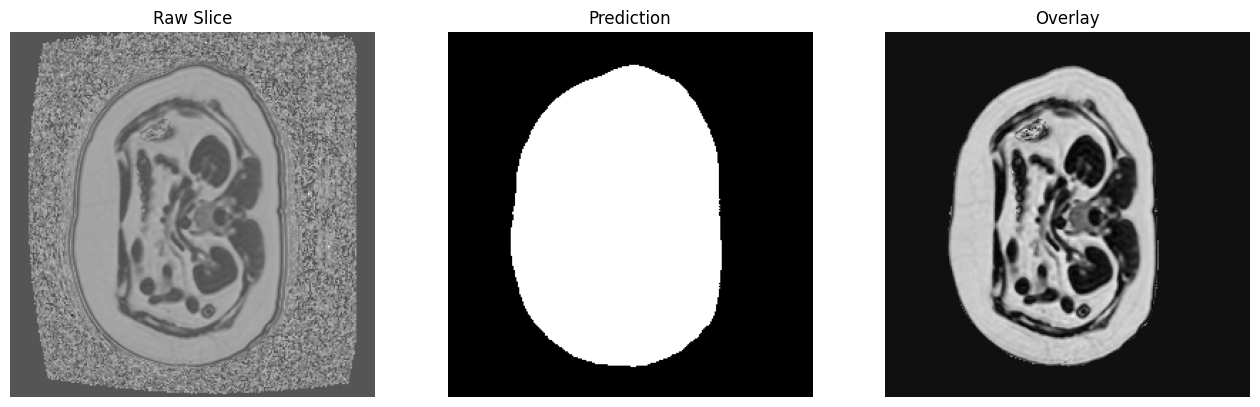

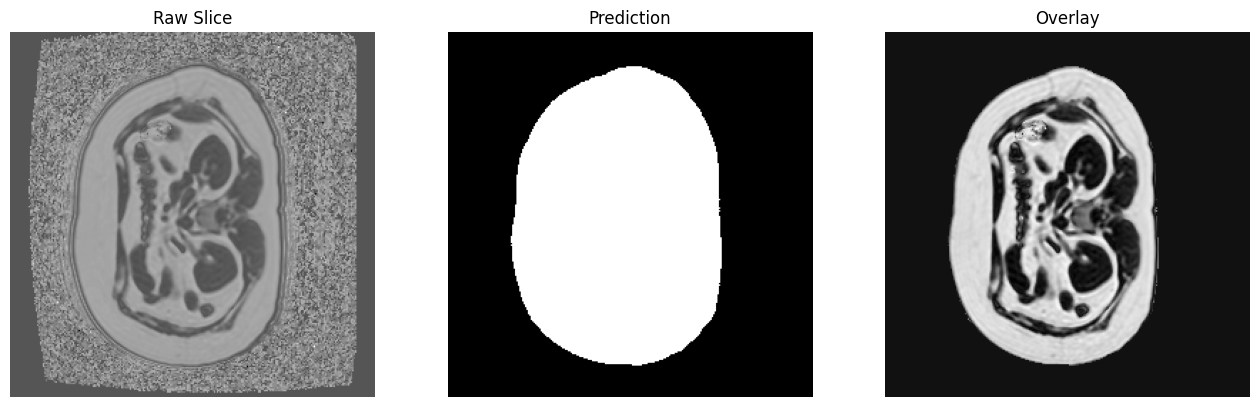

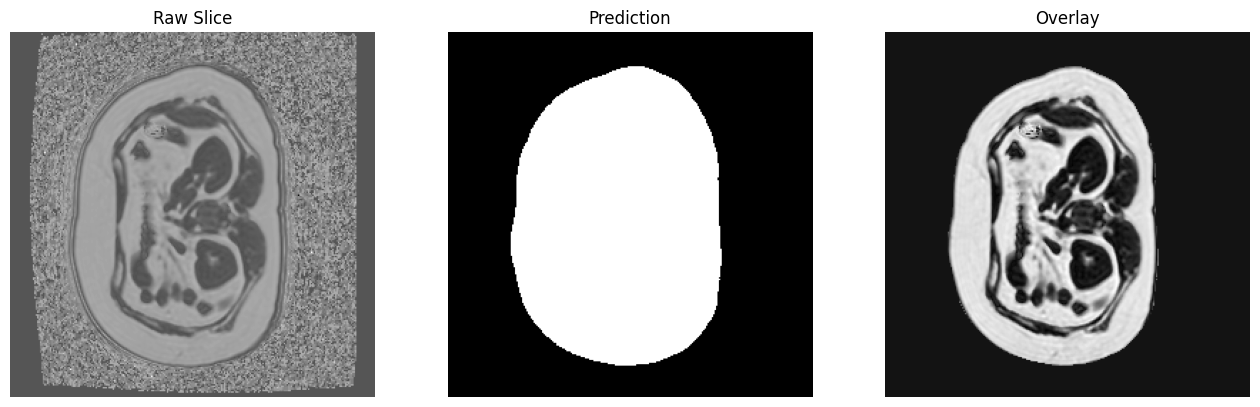

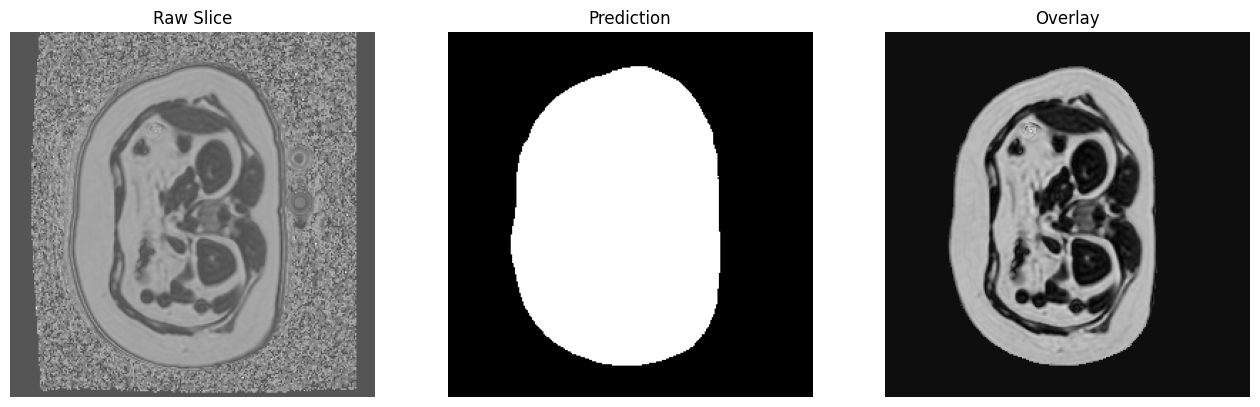

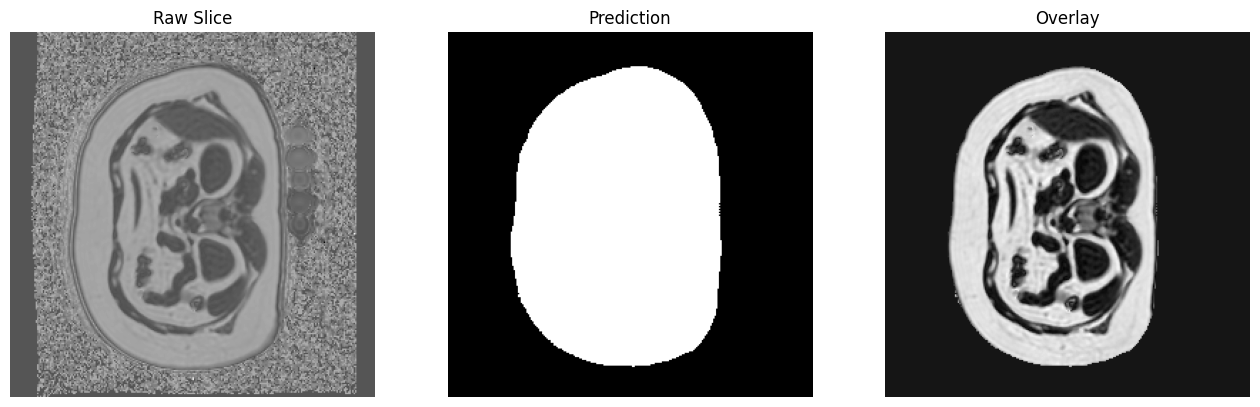

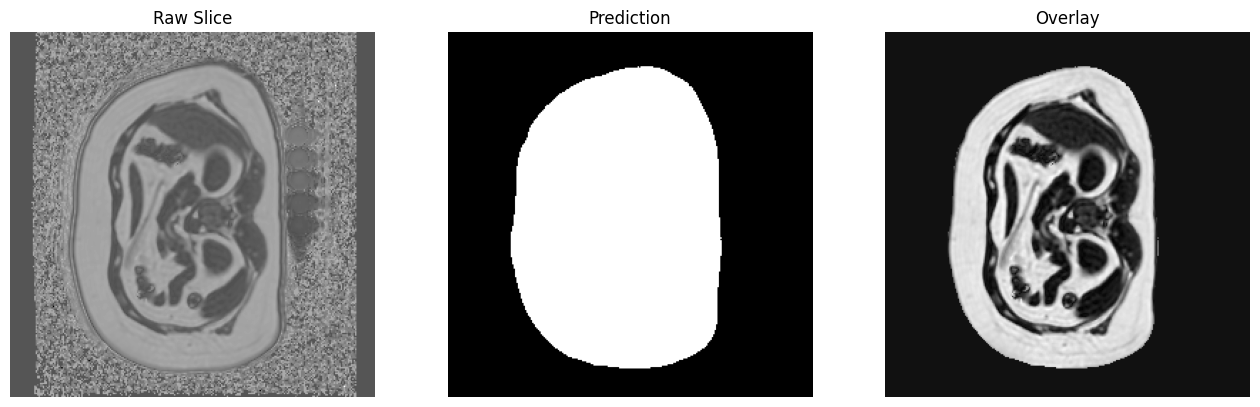

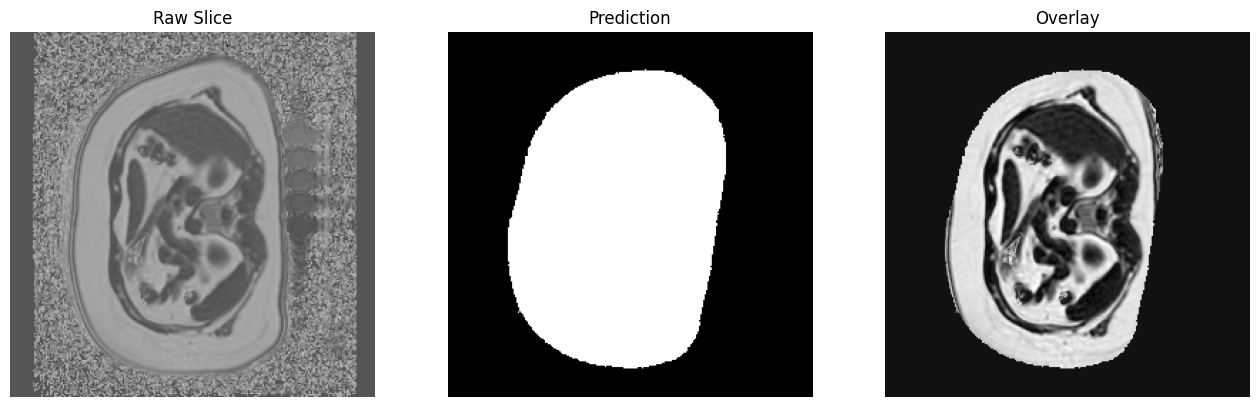

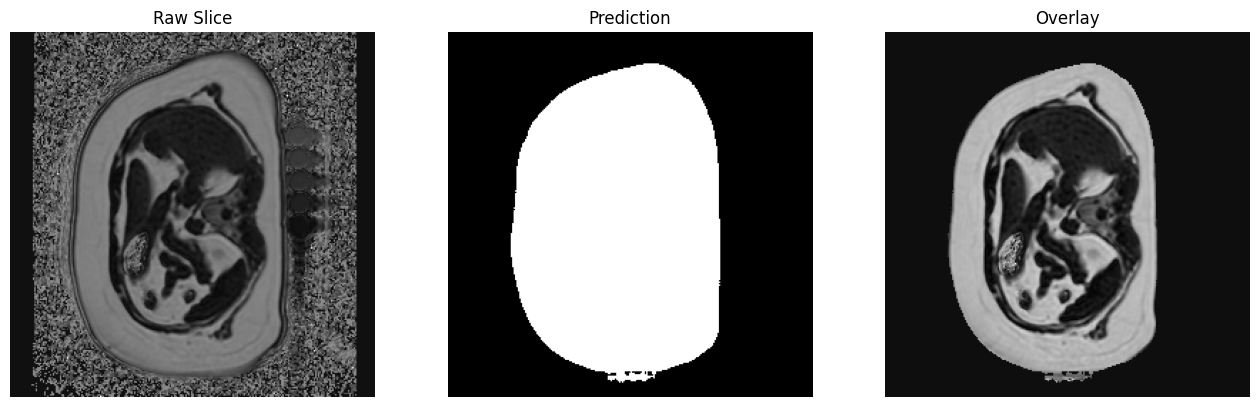

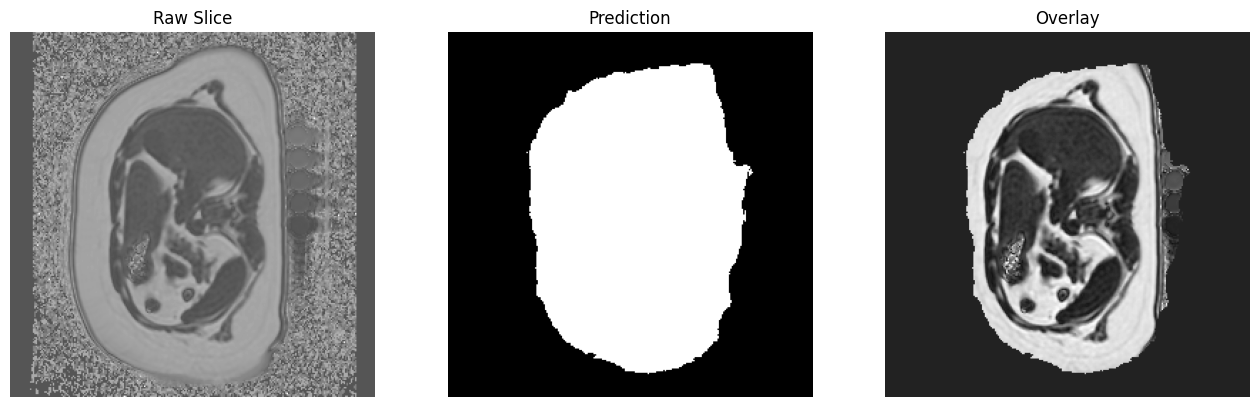

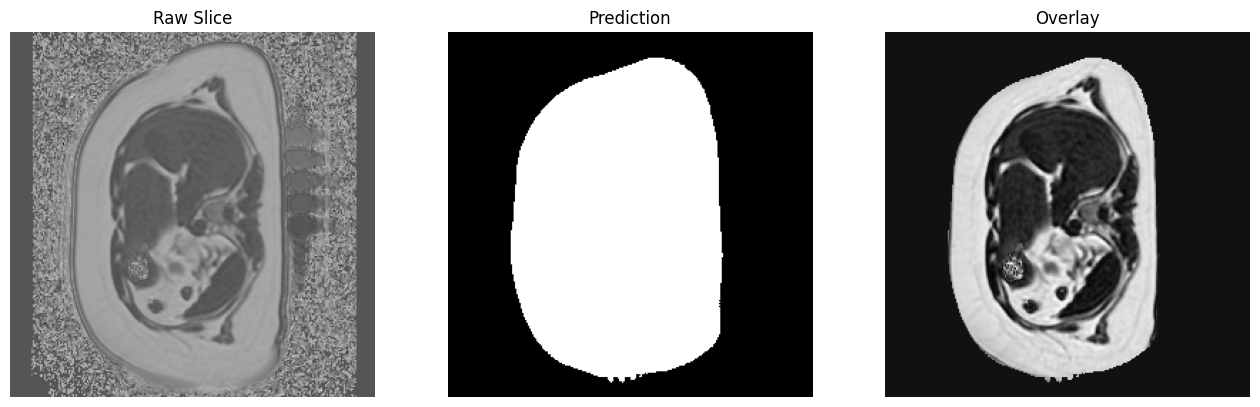

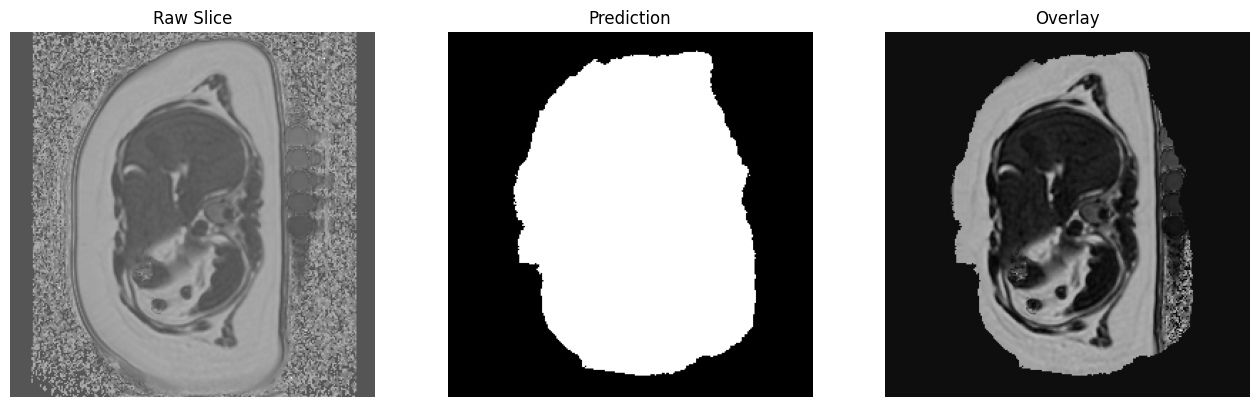

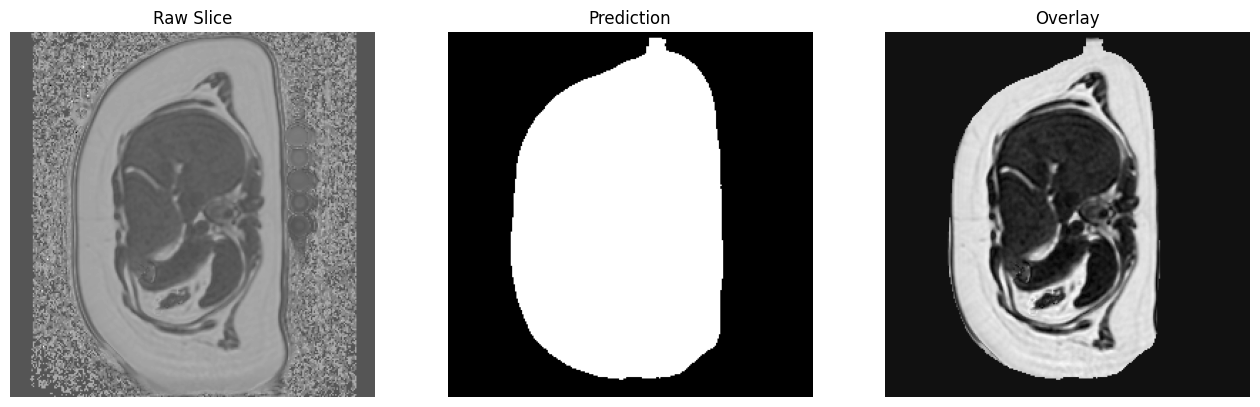

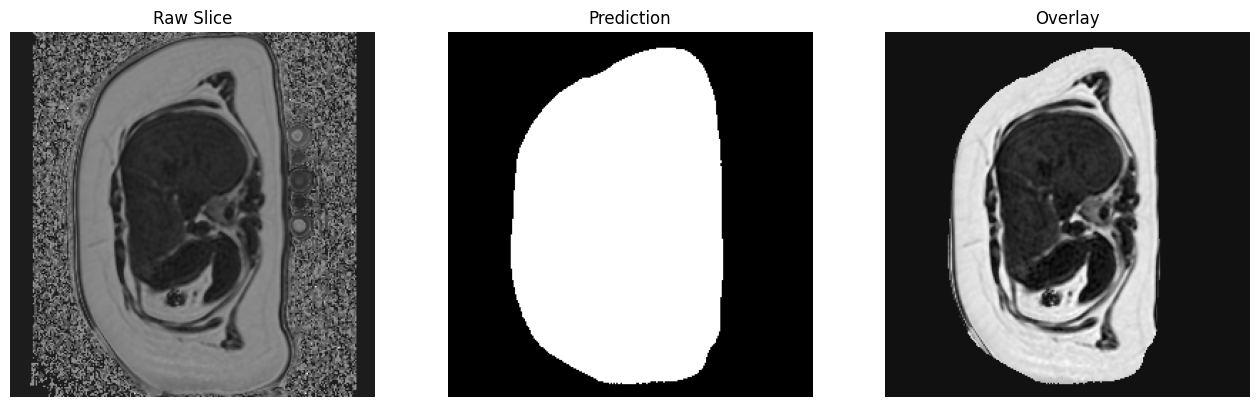

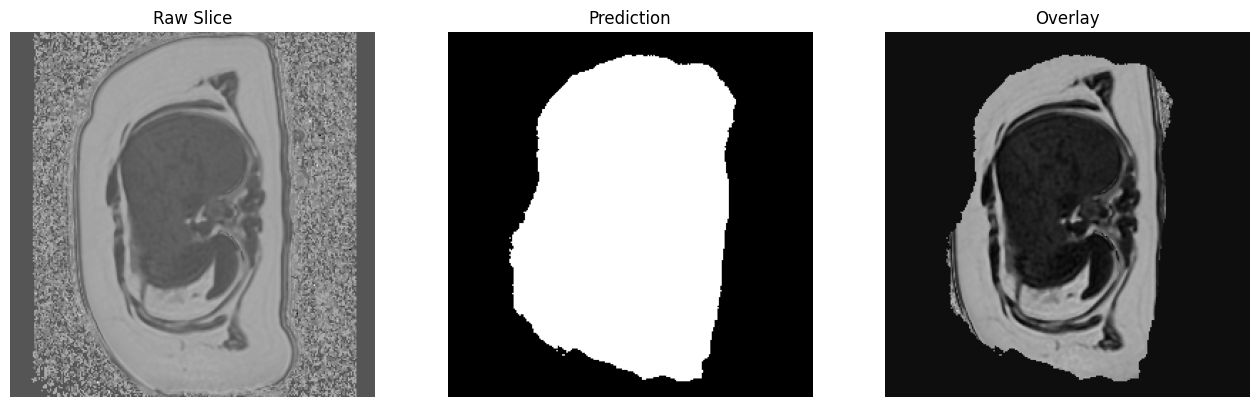

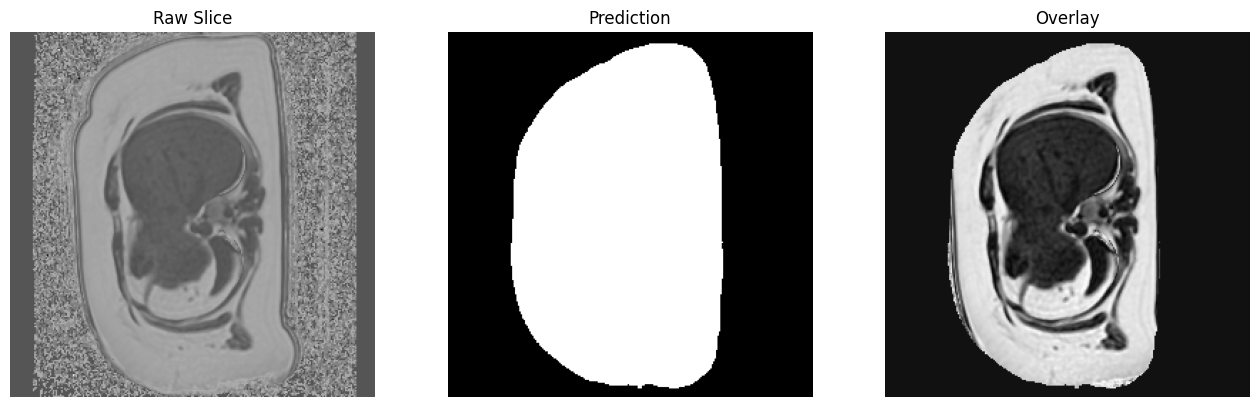

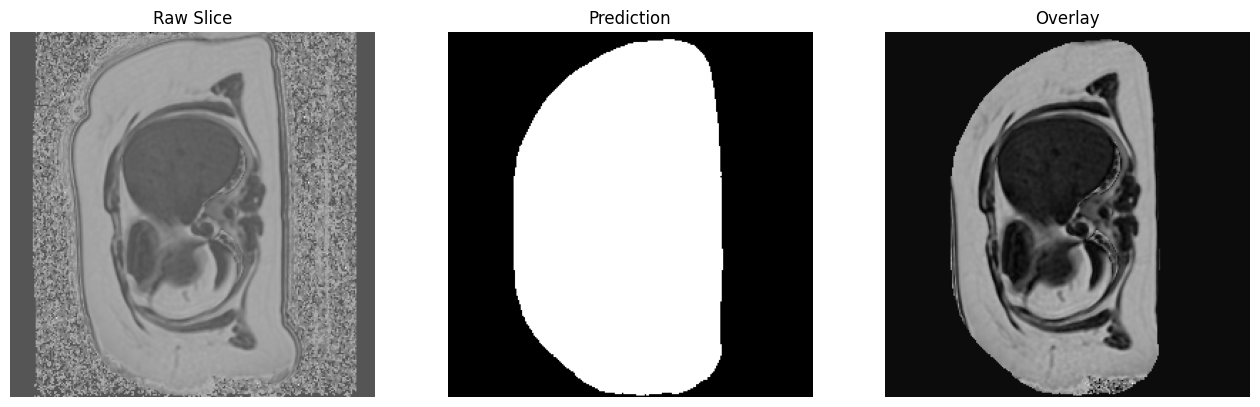

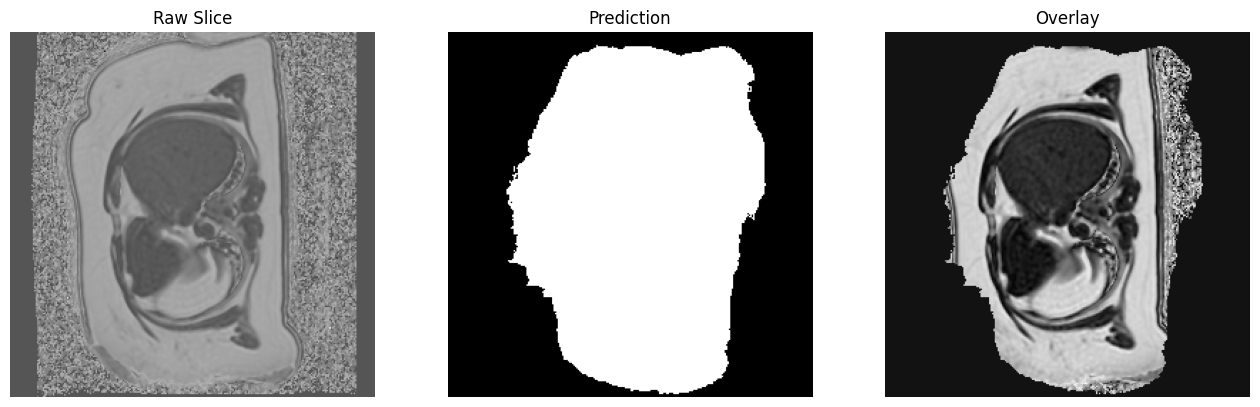

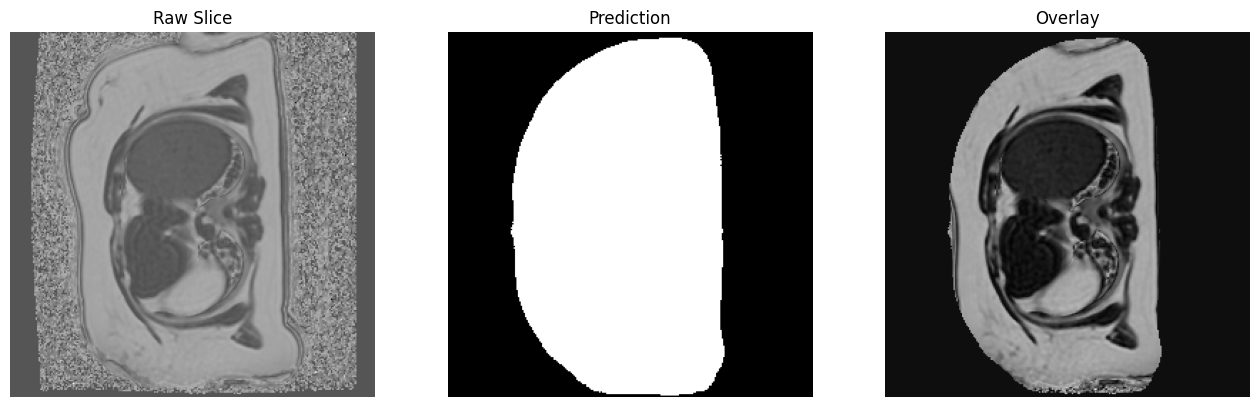

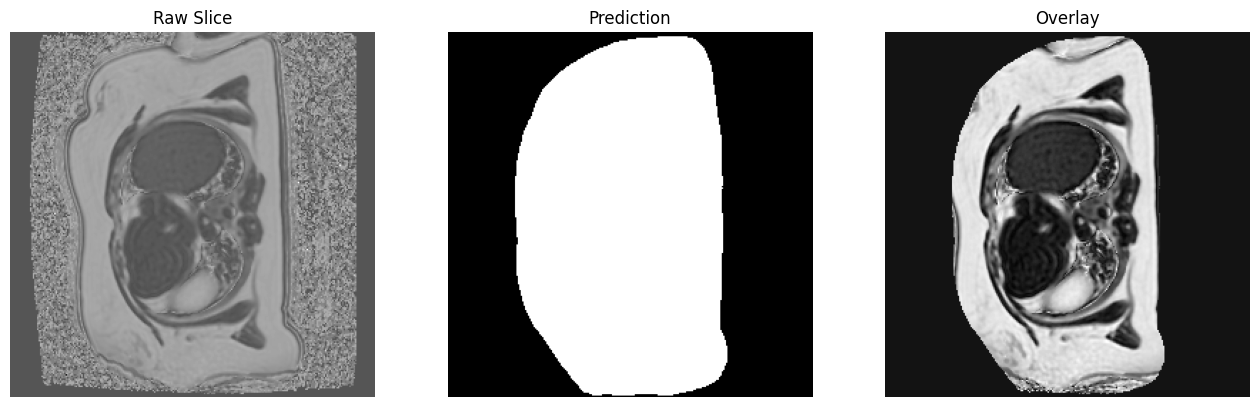

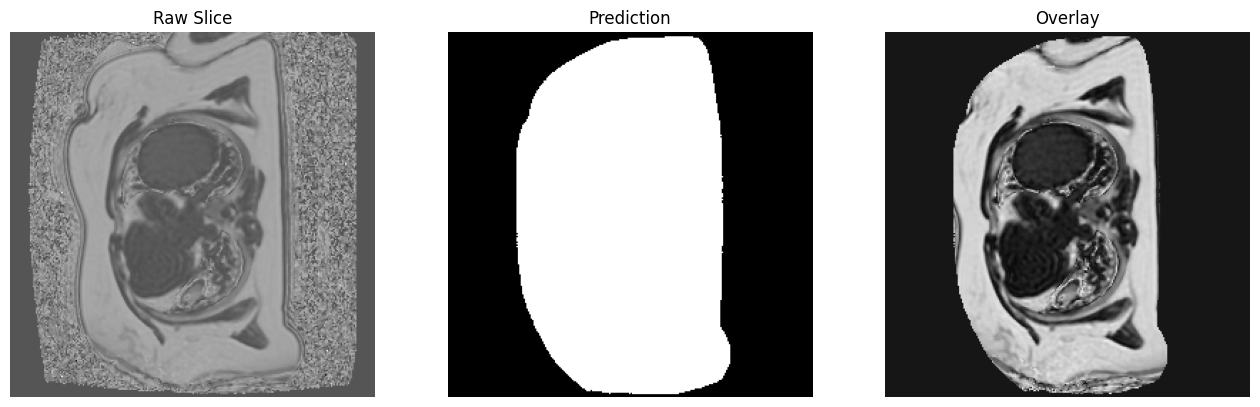

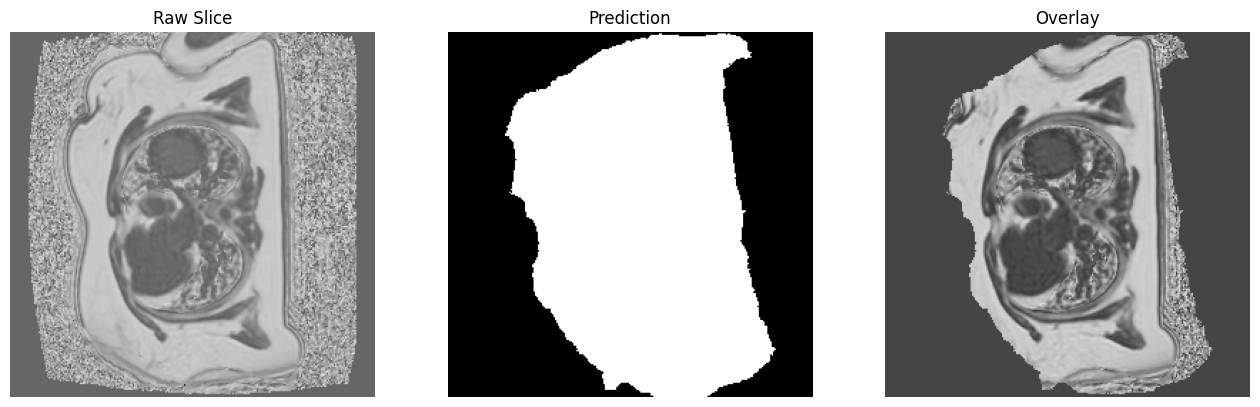

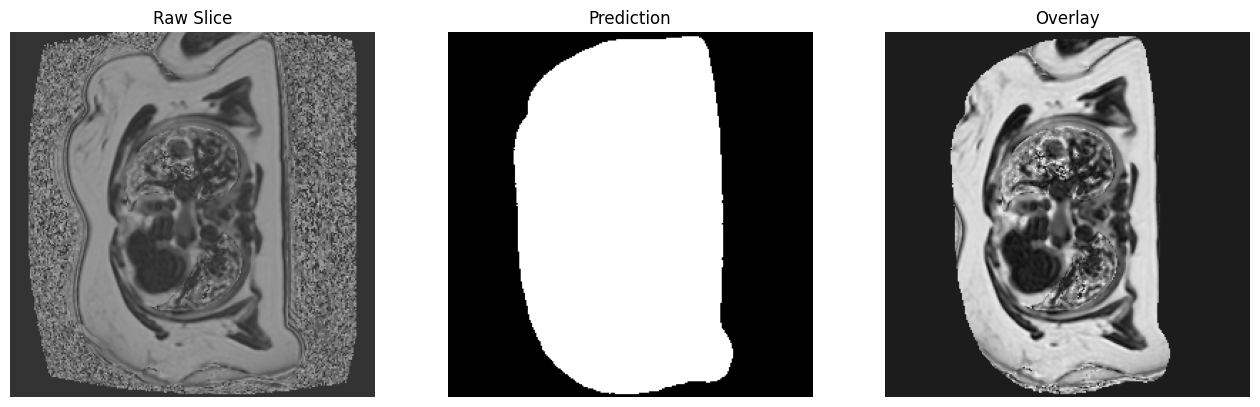

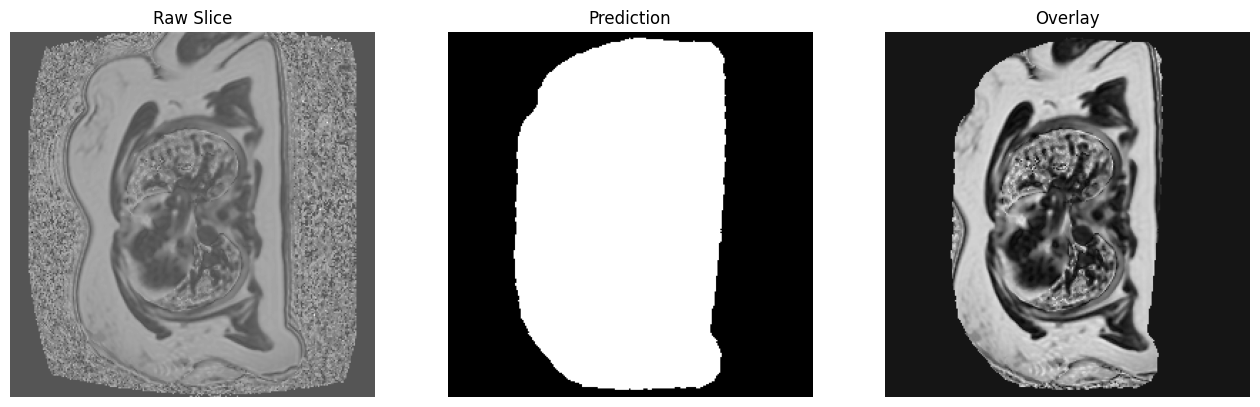

: 

In [ ]:
predictions_directory = 'C:/Users/Mittal/Desktop/thoracic_seg/unet_niipredictions/'
raw_image_directory = 'C:/Users/Mittal/Desktop/thoracic_seg/raw_images/'

raw_images = sorted(os.listdir(raw_image_directory))
predictions = sorted(os.listdir(predictions_directory))

unet_prediction_dataset = []
raw_image_dataset = []
sliced_unet_prediction_dataset = []
sliced_raw_image_dataset = []
image_sizes = []

for image_name in predictions:    
    if (image_name.split('.')[1] == 'nii'):
        base_name = image_name.split('.')[0]
        image = nib.load(predictions_directory+image_name).get_fdata()
        raw = nib.load(raw_image_directory+image_name).get_fdata()
        unet_prediction_dataset.append(np.array(image))
        raw_image_dataset.append(np.array(raw))
        image_sizes.append(image.shape[2])

for i in range(len(unet_prediction_dataset)):
    for j in range(unet_prediction_dataset[i].shape[2]):
        sliced_raw_image_dataset.append(raw_image_dataset[i][:,:,j])
        sliced_unet_prediction_dataset.append(unet_prediction_dataset[i][:,:,j])

for i in range(25):
    plt.figure(figsize=(16, 8))
    plt.subplot(131)
    plt.title('Raw Slice')
    plt.imshow(sliced_raw_image_dataset[i], cmap='gray')
    plt.axis('off')
    plt.subplot(132)
    plt.title('Prediction')
    plt.imshow(sliced_unet_prediction_dataset[i], cmap='gray')
    plt.axis('off')
    plt.subplot(133)
    plt.title('Overlay')
    plt.imshow(sliced_unet_prediction_dataset[i]*sliced_raw_image_dataset[i], cmap='gray')
    plt.axis('off')
    plt.show()
    plt.close()